<a href="https://colab.research.google.com/github/HansHenseler/masdav2024/blob/main/Part_9_Extra%20examples%20for%20visualizing%20and%20analyzing%20Pcap%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nitroba State University Scenario

Scenario Summary:
The scenario revolves around a security investigation at the fictional Nitroba State University in Summer 2008. Lily Tuckrige, a teacher in the Chemistry Department, has been receiving harassing emails that she suspects are being sent by one of her students in the Chemistry 109 class. The harassing emails were initially sent directly to her personal email account, but later, on July 21st, a message was sent through a web-based service called "willselfdestruct.com," which displays the message briefly before destroying it.

The university’s IT department identified that the emails originated from the IP address 140.247.62.34, associated with a student dorm room. The dorm room had an unsecured Wi-Fi router, allowing multiple people to potentially access the network. To identify the perpetrator, the university placed a network sniffer on the Ethernet port to capture all network traffic. Your task is to analyze the captured pcap file to determine if one of the students was responsible for the harassing emails, providing clear and conclusive evidence.

The investigation involves analyzing network traffic, identifying relevant protocols and connections, and correlating this information with the timeline and known IP addresses.

In [ ]:
!pip install folium
!pip install dpkt
!pip install geoip2

In [ ]:
!wget "http://downloads.digitalcorpora.org/corpora/scenarios/2008-nitroba/nitroba.pcap"
!wget "https://git.io/GeoLite2-City.mmdb"

In [52]:
import dpkt
import socket
from datetime import datetime, timedelta
import pandas as pd
import geoip2.database
import folium
import numpy as np
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt


## Step 1: Load and Parse the pcap File
First, let's extract IP addresses and other relevant details from the pcap file.

In [49]:
def print_packet_info(pcap_file):
    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            ip = eth.data

            if isinstance(ip, dpkt.ip.IP):
                src_ip = socket.inet_ntoa(ip.src)
                dst_ip = socket.inet_ntoa(ip.dst)

                # Convert timestamp to a readable date-time format
                readable_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

                # Print out the packet info with readable date-time
                print(f'Time: {readable_time}, Source IP: {src_ip}, Destination IP: {dst_ip}')

# Replace 'file.pcap' with the actual file path

print_packet_info('nitroba.pcap')


Streaminguitvoer ingekort tot de laatste 5000 regels.
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 192.168.15.4, Destination IP: 66.11.48.136
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 192.168.15.4, Destination IP: 66.11.48.136
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 192.168.15.4, Destination IP: 66.11.48.136
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 192.168.15.4, Destination IP: 66.11.48.136
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Destination IP: 192.168.15.4
Time: 2008-07-22 06:09:41, Source IP: 66.11.48.136, Des

## Step 2: Get unique src,dst pairs
Can you write a function that generates a dataframe of all unique src,dst pairs?

In [ ]:


def generate_ip_pairs_dataframe(pcap_file):
    pairs = {}

    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            ip = eth.data

            if isinstance(ip, dpkt.ip.IP):
                src_ip = socket.inet_ntoa(ip.src)
                dst_ip = socket.inet_ntoa(ip.dst)

                # Create a tuple of the src, dst pair
                pair = (src_ip, dst_ip)

                # If the pair exists, increment its count, otherwise initialize it
                if pair in pairs:
                    pairs[pair]['count'] += 1
                else:
                    readable_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
                    pairs[pair] = {'first_seen': readable_time, 'count': 1}

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame([
        {'Source IP': src, 'Destination IP': dst, 'First Seen': data['first_seen'], 'Count': data['count']}
        for (src, dst), data in pairs.items()
    ])

    return df

# Example usage:
# Replace 'file.pcap' with the actual file path
df = generate_ip_pairs_dataframe('nitroba.pcap')

# Display the DataFrame
print(df)


         Source IP   Destination IP           First Seen  Count
0     192.168.1.64     74.125.19.83  2008-07-22 01:51:07      2
1     74.125.19.83     192.168.1.64  2008-07-22 01:51:07      2
2     192.168.1.64     74.125.19.19  2008-07-22 01:51:07    176
3     74.125.19.19     192.168.1.64  2008-07-22 01:51:07    172
4     192.168.1.64    192.168.1.254  2008-07-22 01:51:07    333
..             ...              ...                  ...    ...
874  38.102.35.231     192.168.15.4  2008-07-22 06:11:19      5
875   192.168.15.4      199.7.71.72  2008-07-22 06:11:35      6
876    199.7.71.72     192.168.15.4  2008-07-22 06:11:35      6
877   192.168.15.8      224.0.0.251  2008-07-22 06:11:53      2
878   192.168.15.8  255.255.255.255  2008-07-22 06:12:42      4

[879 rows x 4 columns]


## Step 3: for each IP address that is http related adds a hostname and a geo location
Write a function that for each IP address that is http related adds a hostname and a geo location. If a geo location is not known you can skip it. I want to use the output to visualise ip addresses using folium and us the hostname as a label

In [ ]:
def process_pcap_for_http_geo(pcap_file, geoip_db_path):
    locations = []

    # Open the GeoLite2 database
    with geoip2.database.Reader(geoip_db_path) as reader:
        with open(pcap_file, 'rb') as f:
            pcap = dpkt.pcap.Reader(f)

            for timestamp, buf in pcap:
                eth = dpkt.ethernet.Ethernet(buf)
                ip = eth.data

                if isinstance(ip, dpkt.ip.IP):
                    src_ip = socket.inet_ntoa(ip.src)
                    dst_ip = socket.inet_ntoa(ip.dst)

                    # Check if the packet is an HTTP request
                    if isinstance(ip.data, dpkt.tcp.TCP):
                        tcp = ip.data
                        try:
                            http = dpkt.http.Request(tcp.data)

                            # Extract host from HTTP headers, or use destination IP if not available
                            hostname = http.headers.get('host', dst_ip)

                            # Get the geo-location of the destination IP
                            try:
                                response = reader.city(dst_ip)
                                lat = response.location.latitude
                                lon = response.location.longitude

                                # Add the location info to the list
                                locations.append({
                                    'ip': dst_ip,
                                    'hostname': hostname,
                                    'lat': lat,
                                    'lon': lon
                                })
                            except geoip2.errors.AddressNotFoundError:
                                # Skip if geo-location is not found
                                continue

                        except (dpkt.dpkt.UnpackError, AttributeError):
                            continue

    return locations

# Example usage:
# Replace 'file.pcap' with the actual pcap file path and 'GeoLite2-City.mmdb' with the path to the GeoLite2 database
locations = process_pcap_for_http_geo('nitroba.pcap', 'GeoLite2-City.mmdb')

# Print the results
for location in locations:
    print(location)


It's big and I see many duplicates. Let's keep the function as it is but let's groupby and make a similar dataframe that has the number of times the website is occuring

In [ ]:
def group_locations_by_hostname(locations):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(locations)

    # Group by hostname and aggregate
    grouped_df = df.groupby(['hostname', 'lat', 'lon']).size().reset_index(name='count')

    return grouped_df

# Example usage:
grouped_df = group_locations_by_hostname(locations)

# Display the grouped DataFrame
grouped_df


,hostname,lat,lon,count
0,0.channel14.facebook.com,37.7510,-97.8220,6
1,0.channel14.facebook.com:80,37.7510,-97.8220,1
2,165.193.233.120,51.4223,-0.1984,2
3,194.129.79.21,51.4964,-0.1224,1
4,204.2.166.34,37.7510,-97.8220,1
...,...,...,...,...
336,www.youtube.com,37.7510,-97.8220,11
337,www999.shopping.com,37.7510,-97.8220,21
338,yui.yahooapis.com,37.7510,-97.8220,1
339,z-ecx.images-amazon.com,37.7510,-97.8220,16


## Step 4: Visualize using Folium

In [ ]:
def visualize_grouped_locations_on_map(grouped_df):
    # Create a map centered at a default location (e.g., Nitroba University)
    m = folium.Map(location=[42.3601, -71.0589], zoom_start=3)

    # Determine the scale for marker sizes
    max_count = grouped_df['count'].max()

    for _, row in grouped_df.iterrows():
        # Use a logarithmic scale for the marker size
        # Add a small constant (e.g., 1) to avoid log(0) and ensure a minimum marker size
        marker_size = np.log1p(row['count']) / np.log1p(max_count) * 30  # Scaling factor 20 for visibility

        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=marker_size,  # Radius proportional to the logarithm of count
            popup=f"{row['hostname']} ({row['count']} times)",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(m)

    # Display the map in the notebook
    return m

# Visualize the grouped locations inline in the notebook
map_object = visualize_grouped_locations_on_map(grouped_df)
map_object  # This will display the map inline in Google Colab


## Step 5: Gettings statistics on protocols

In [53]:
def get_protocol_name(protocol, port):
    # Common TCP ports
    tcp_ports = {
        20: "FTP", 21: "FTP", 22: "SSH", 23: "Telnet", 25: "SMTP", 53: "DNS",
        80: "HTTP", 110: "POP3", 143: "IMAP", 443: "HTTPS", 465: "SMTPS",
        587: "SMTP Auth", 993: "IMAPS", 995: "POP3S"
    }

    # Common UDP ports
    udp_ports = {
        53: "DNS", 67: "DHCP", 68: "DHCP", 69: "TFTP", 123: "NTP",
        161: "SNMP", 162: "SNMP", 500: "IKE"
    }

    # Add additional port mappings for ports > 1000
    additional_tcp_ports = {
        1433: "SQL Server", 1521: "Oracle DB", 1723: "PPTP", 3306: "MySQL",
        3389: "RDP", 5900: "VNC", 8080: "HTTP Alternate"
    }

    additional_udp_ports = {
        1434: "SQL Server", 1812: "RADIUS", 2049: "NFS", 4500: "IPSec NAT-T"
    }

    if protocol == "TCP":
        return tcp_ports.get(port) or additional_tcp_ports.get(port) or f"TCP port {port}"
    elif protocol == "UDP":
        return udp_ports.get(port) or additional_udp_ports.get(port) or f"UDP port {port}"
    else:
        return f"Port {port}"  # For other protocols or unknown ports

def extract_protocol_statistics(pcap_file):
    data = []

    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            ip = eth.data

            if isinstance(ip, dpkt.ip.IP):
                protocol_name = "Other"
                port = None

                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    port = tcp.dport if tcp.dport < 1000 else None
                    protocol_name = get_protocol_name("TCP", port)

                elif isinstance(ip.data, dpkt.udp.UDP):
                    udp = ip.data
                    port = udp.dport if udp.dport < 1000 else None
                    protocol_name = get_protocol_name("UDP", port)

                elif isinstance(ip.data, dpkt.icmp.ICMP):
                    protocol_name = "ICMP"

                # Convert timestamp to a datetime object rounded to the nearest 5-minute interval
                time = datetime.utcfromtimestamp(timestamp)
                time = time - timedelta(minutes=time.minute % 5, seconds=time.second, microseconds=time.microsecond)

                data.append({'time': time, 'protocol': protocol_name})

    return pd.DataFrame(data)

def group_by_protocol_and_time(df_protocols):
    # Group by time and protocol, then count the number of packets per group
    grouped = df_protocols.groupby(['time', 'protocol']).size().unstack(fill_value=0)

    # Sort the index (time) to ensure correct order for plotting
    grouped.sort_index(inplace=True)

    return grouped

# Example usage:
df_protocols = extract_protocol_statistics('nitroba.pcap')
grouped_df = group_by_protocol_and_time(df_protocols)

# Display the grouped DataFrame
grouped_df.head()  # Displaying the first few rows


protocol,DNS,HTTP,HTTPS,ICMP,IKE,NTP,Other,TCP port None,Telnet,UDP port 520,UDP port None
time,,,,,,,,,,,
2008-07-22 01:50:00,36,3978,84,0,0,2,0,5258,0,0,66
2008-07-22 01:55:00,38,344,55,0,0,2,0,424,0,0,80
2008-07-22 02:00:00,39,0,23,0,0,2,0,37,0,0,121
2008-07-22 02:05:00,27,0,19,3,0,3,0,19,0,0,106
2008-07-22 02:10:00,63,0,6,0,0,1,0,0,0,0,29


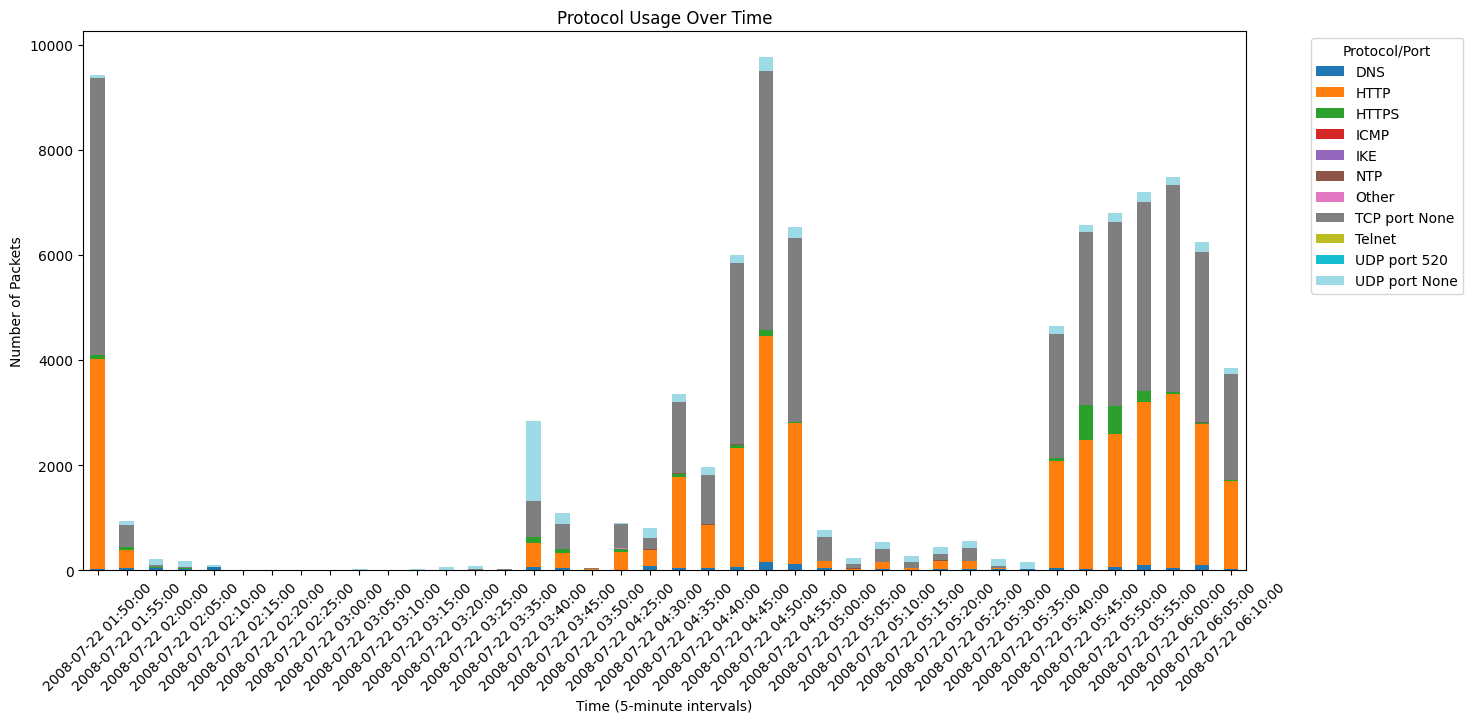

In [54]:
import matplotlib.pyplot as plt

def plot_protocol_statistics(grouped_df):
    # Plot the data as a stacked bar plot
    ax = grouped_df.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='tab20')

    # Set plot labels and title
    ax.set_ylabel('Number of Packets')
    ax.set_xlabel('Time (5-minute intervals)')
    ax.set_title('Protocol Usage Over Time')
    ax.legend(title='Protocol/Port', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

# Example usage:
plot_protocol_statistics(grouped_df)


## Step 6: Visualize response and request bodies

In [61]:
# Define printable characters (common ASCII characters that are typically "printable")
printable = set(string.printable)

def extract_http_text_for_wordcloud(pcap_file):
    text_data = []

    with open(pcap_file, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            ip = eth.data

            if isinstance(ip, dpkt.ip.IP):
                if isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    if len(tcp.data) > 0:
                        try:
                            # Parse the packet as an HTTP request
                            http_request = dpkt.http.Request(tcp.data)
                            hostname = http_request.headers.get('host', '')
                            request_body = http_request.body.decode('utf-8', errors='ignore')
                            # Keep only printable characters
                            request_body = ''.join(filter(lambda x: x in printable, request_body))
                            text_data.append(f"{hostname} {request_body}")
                        except (dpkt.dpkt.UnpackError, AttributeError):
                            pass

                        try:
                            # Parse the packet as an HTTP response
                            http_response = dpkt.http.Response(tcp.data)
                            response_body = http_response.body.decode('utf-8', errors='ignore')
                            # Keep only printable characters
                            response_body = ''.join(filter(lambda x: x in printable, response_body))
                            text_data.append(response_body)
                        except (dpkt.dpkt.UnpackError, AttributeError):
                            pass

    # Concatenate all the extracted text data into a single string
    concatenated_text = ' '.join(text_data)
    return concatenated_text

# Example usage:
pcap_file = 'nitroba.pcap'
concatenated_text = extract_http_text_for_wordcloud(pcap_file)


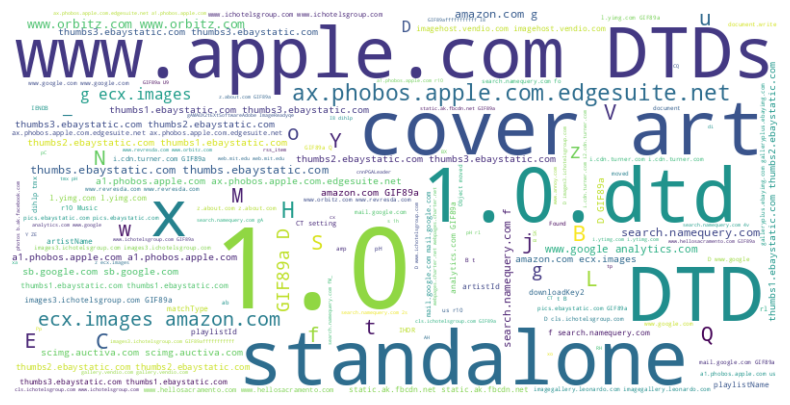

In [68]:
from wordcloud import STOPWORDS

# Define additional stopwords (HTML/XML tags and other common words)
custom_stopwords = set(STOPWORDS).union({
    'html', 'body', 'div', 'span', 'head', 'title', 'script', 'style', 'footer', 'header',
    'section', 'article', 'nav', 'br', 'hr', 'strong', 'em', 'p', 'a', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6',
    'img', 'src', 'alt', 'href', 'table', 'tr', 'td', 'th', 'ul', 'li', 'ol', 'dl', 'dt', 'dd',
    'meta', 'link', 'input', 'form', 'name', 'id', 'class', 'value', 'http', 'https', 'www', 'com',
    'jpg', 'png', 'gif', 'css', 'js', 'xml', 'version', 'encoding', 'utf', 'content', 'type',
    'DOCTYPE', 'address', 'email', 'submit', 'click', 'button', 'key', 'string', 'plist', 'computer', 'status',
    'phobos', 'apple', 'integer', 'url', 'request', 'dict', 'en', 'propertylist', 'public', 'delay', 'seconds'
})

def generate_wordcloud(text):
    # Create a word cloud object with custom stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,  # Include custom stopwords
        regexp=r'\b[\w\.]+\b'  # Custom regex to match words with dots
    ).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Example usage:
generate_wordcloud(concatenated_text)
